In [2]:
# import pandas as pd
# import numpy as np
# from numpy.random import RandomState


# # 经营、司法(0.11595)

raw_data = pd.read_csv("./dataSets/raw_data.csv", encoding="gbk")
# out_data = pd.read_csv("./dataSets/output_data.csv", encoding="gbk")
# # # 竞争风险输出值
# Y = out_data.loc[:,["司法"]]
# y_data = np.array(Y)#np.ndarray()
# # y_list =y_data.tolist()#list
# # Y.head()

NameError: name 'pd' is not defined

In [ ]:
# 绘制误差曲线
# t = np.arange(iteration-1)
# plt.figure(figsize = (9,6))
# plt.plot(t, np.array(error), 'b*')
# plt.xlabel("iteration")
# plt.ylabel("error")
# plt.legend(['error'], loc='upper right')
# plt.show()

# 使用线性回归的方法进行数据曲线拟合
# from sklearn import linear_model
# from sklearn.externals import joblib

# mlr = linear_model.LinearRegression()

# model = mlr.fit(x_train, y_train)
# joblib.dump(model,'rf.model')

# print(mlr)
# print ("coef:")
# print(mlr.coef_)
# print ("intercept")
# print( mlr.intercept_)

# #xPredict =  x_test[0].tolist()
# # # xPredict
# yPredict = mlr.predict(x_test)
# # # # print "predict:"
# print(yPredict)


In [9]:
import tensorflow as tf
import  os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print("tensorflow运行版本：" + tf.__version__)
# CNN 回归预测
sess = tf.Session()
#变厚矩阵
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name="w")
#偏置
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name="b")

#卷积处理 变厚过程
def conv2d(x, W):
    
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
#pool 长宽缩小一倍
def max_pool_2x2(x):
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# define placeholder for inputs to network
xs = tf.placeholder("float", shape=[None, 6], name = 'input_x') #原始数据的维度：9
ys = tf.placeholder("float", shape=[None, 1])#输出数据为维度：1
 
keep_prob = tf.placeholder(tf.float32, name="keep_prob")  # dropout的比例

# -1 数据数量不定2*3*1通道为1
x_image = tf.reshape(xs, [-1, 2, 3, 1])  # 原始数据16变成二维图片4*4



#  conv1 layer  第一卷积层
W_conv1 = weight_variable([2, 2, 1, 12])  # 卷积核大小patch 2x2, 图像通道数in size 1, 卷积核数目out size 6,
#  每个卷积核对应一个偏置量
b_conv1 = bias_variable([12])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)  # output size 2x2x32，长宽不变，高度为32的三维图像
#  h_pool1 = max_pool_2x2(h_conv1)     # output size 2x2x32 长宽缩小一倍


## conv2 layer  第二卷积层 6个通道卷积, 卷积出12个特征
W_conv2 = weight_variable([2, 2, 12, 24])  # patch 2x2, in size 32, out size 64
b_conv2 = bias_variable([24])
h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2) # 输入第一层的处理结果 输出shape 4*4*64

# fc1 layer ##  full connection 全连接层
W_fc1 = weight_variable([2*3*24, 144])  # 3x3 ，高度为64的三维图片，然后把它拉成512长的一维数组
b_fc1 = bias_variable([144])

h_pool2_flat = tf.reshape(h_conv2, [-1, 2*3*24])  # 把4*4，高度为64的三维图片拉成一维数组 降维处理
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)    # dropout层
# fc2 layer ## full connection

with tf.name_scope('output'):
    W_fc2 = weight_variable([144, 1])
    b_fc2 = bias_variable([1])  # 偏置
    # 最后的计算结果
    multi = tf.matmul(h_fc1_drop, W_fc2)
    pred = tf.add(multi, b_fc2, name="predict")

# 计算 predition与y 差距 所用方法很简单就是用 suare()平方,sum()求和,mean()平均值
cross_entropy = tf.reduce_mean(tf.reduce_sum(tf.square(ys - pred), reduction_indices=[1]))
# 0.01学习效率,minimize(loss)减小loss误差
train_step = tf.train.AdamOptimizer(0.004).minimize(cross_entropy)
sess.run(tf.global_variables_initializer())

tensorflow运行版本：1.9.0


In [10]:
from functools import reduce
def pingjun(L=[]):
    a=reduce(lambda x,y:x+y,L)
    return a*1.0/len(L)
#获取平均数
def Get_Average(list):
   sum = 0
   for item in list:     
      sum += item  
   return sum/len(list)
 

In [11]:
# 训练模型
def train_model(x_train, y_train, iteration):
    error = []
    for i in range(iteration):
        sess.run(train_step, feed_dict={xs: x_train, ys: y_train, keep_prob: 0.6})
        err = sess.run(cross_entropy, feed_dict={xs: x_train, ys: y_train, keep_prob: 1.0})
        print(i, '误差=',err)  # 输出loss值
        error.append(err) 
    # 计算平均误差
    ave_error = Get_Average(error)
    print("平均误差为：%f " % ave_error)   
    # 保存模型
#     output_graph_def = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, output_node_names=['output/predict'])
#     with tf.gfile.FastGFile(model_name, mode='wb') as f:
#         f.write(output_graph_def.SerializeToString())
#         print("Model Save succesfull!")

In [3]:
import pandas as pd
import numpy as np
import xlrd as xd
from numpy.random import RandomState
import  os

# 依次建立成长力、筹资力、流动性、清偿力四大财务风险指标；20180823午
# 加载全部数据包括四个模型数据,数据预处理
#load_data = pd.read_excel("./dataSets/DEA三级到二级.xlsx", encoding="gbk")

raw_data = pd.read_csv("./dataSets/raw_data.csv", encoding="gbk")

# col_cz  = ["营业收入增长率","总资产增长率","净资产收益率","总资本盈利率","现金收入比","购建固定资产及无形资产和其他长期资产支付的现金（"]
# col_czi = ["纳税信用等级","财务费用率","产权比率","速动比率","现金比率","现金流量债务比"]
col_ld  = ["流动资产周转率","应收账款周转率","流动资产合计","非流动资产合计","流动负债合计","营运资本周转率"]
# col_qc  = ["流动资产","流动负债","资产总计","净利润","所得税","经营现金流量净额"]
# # 各指标特征
# CZ_features  =  raw_data.loc[:, col_cz]
# CZI_features =  raw_data.loc[:, col_czi]
#LD_features  =  raw_data.loc[:, col_ld]
# QC_features  =  raw_data.loc[:, col_qc]
# # 各指标 输出
# CZ_y  = raw_data.loc[:,["成长力"]]
# CZI_y = raw_data.loc[:,["筹资力"]]
#LD_y  = raw_data.loc[:,["流动性"]]
# QC_y  = raw_data.loc[:,["清偿力"]]
raw_data

/home/lihanghang/anaconda3/envs/TensorFlow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,公司名称,流动性 财务风险-流动性风险-流动资产周转率,财务风险-流动性风险-应收账款周转率,筹资方面财务风险-筹资风险-纳税信用等级,财务风险-筹资风险-征信信用等级,财务风险-筹资风险-1/财务费用率,财务风险-筹资风险-1/产权比率,财务风险-筹资风险-融资轮次,财务风险-筹资风险-股权出质总计,对外投资数量,...,司法方面---经营风险-司法风险-诉讼数量,经营风险-其它风险-经营异常次数,经营风险-其它风险-行政处罚次数,经营风险-其它风险-动产质押次数,经营风险-其它风险-自身风险,经营风险-其它风险-周边风险,组织方面---经营风险-组织结构风险-股东数量（注册）,经营风险-组织结构风险-第一大股东持股比例（注册）,竞品信息,经营风险-战略风险-公众号数
0,万邦联合（北京）设备有限公司,1.308838,1.280600e+01,11.0,11,1.429929e+03,1.281763e+00,0,0,1,...,0,0,0,0,0,0,2,0.8500,0,0
1,三环永磁（北京）科技有限公司,0.944185,2.372317e+00,10.0,10,-2.102954e+03,6.456290e+00,0,0,2,...,0,0,0,0,0,2,2,0.6000,0,0
2,世纪良基集团有限公司,0.516450,8.177900e+00,9.0,9,9.923423e+00,8.122196e-01,0,0,6,...,1,0,0,0,0,0,3,0.9100,0,0
3,东电创新（北京）科技发展股份有限公司,0.645064,2.610231e+00,9.0,9,2.871513e+02,1.241701e+00,8,0,2,...,0,0,0,0,0,0,5,0.5909,10,1
4,中人时代教育科技（北京）股份有限公司,1.999999,4.749994e+00,15.0,15,3.800000e+06,-7.209301e-01,0,0,4,...,0,0,0,0,0,0,6,0.4237,10,1
5,中信网络科技股份有限公司,2.035528,4.839789e+00,8.0,8,8.923370e+01,1.681607e+00,0,0,0,...,1,0,0,0,0,3,6,0.6500,10,0
6,中关村科技软件股份有限公司,2.133800,2.891860e+01,11.0,11,-3.328760e+03,8.851917e+00,0,0,2,...,1,0,0,0,1,8,9,0.2775,10,0
7,中农博乐科技开发有限公司,1.263116,3.941300e+07,14.0,14,3.941300e+07,3.149971e+00,0,0,1,...,0,0,0,0,0,0,5,0.5500,0,0
8,中博农(北京)牧场建设有限公司,1.775731,1.257642e+01,10.0,10,1.573033e+09,1.831915e+00,0,0,4,...,0,0,0,0,1,1,1,1.0000,0,0
9,中博农畜牧科技股份有限公司,0.972297,2.829738e+00,6.0,6,3.424897e+01,1.336264e+00,4,0,5,...,11,0,0,0,9,16,20,0.4406,10,0


In [20]:
raw_data = pd.read_csv("./dataSets/raw_data.csv", encoding="gbk")
out_data = pd.read_csv("./dataSets/output_data.csv", encoding="gbk")
col_n = ['经营力方面---财务风险-盈利能力-销售净利率','财务风险-盈利能力-总资产报酬率', '财务风险-盈利能力-净资产收益率','财务风险-资产利用-存货周转率'
       ,'财务风险-资产利用-总资产周转率', '财务风险-资产利用-成本费用利润率']

col_ns = ["司法方面---经营风险-司法风险-诉讼数量","经营风险-其它风险-经营异常次数","经营风险-其它风险-行政处罚次数","经营风险-其它风险-动产质押次数","经营风险-其它风险-自身风险","经营风险-其它风险-周边风险"]
jingying =  raw_data.loc[:594, col_n].values
sifa = raw_data.loc[:594, col_ns].values
jy_Y = out_data.loc[:594,["经营"]].values
sf_Y = out_data.loc[:594,["司法"]].values
jingying_test =  raw_data.loc[594:696, col_n]
sifa_test = raw_data.loc[594:696, col_ns].values
jy_Y_test = out_data.loc[594:696,["经营"]].values
sf_Y_test = out_data.loc[594:696,["司法"]].values
#raw_data  = load_data.fillna(0)


# 切分训练测试数据
from sklearn.model_selection import train_test_split
def split_x_y(x,y_data):
#     x_3 = x[:,3:6]
#     x_=np.column_stack([x,x_3])#随意给x增加了3列，x变为16列，可以reshape为3*3矩阵正方形
    x_train, x_test, y_train, y_test = train_test_split(
    x, y_data, train_size=1, random_state=123) # 参数test_size设置训练集占比
    return x_train, x_test, y_train, y_test
jy_Y_test

array([[0.54708935],
       [0.47989379],
       [0.55168097],
       [0.48097958],
       [0.578352  ],
       [0.58744467],
       [0.53760705],
       [0.60434787],
       [0.45925099],
       [0.48832074],
       [0.48866416],
       [0.77155098],
       [0.53163772],
       [0.71195791],
       [0.48818247],
       [0.46718881],
       [0.26507454],
       [0.48970829],
       [0.48824577],
       [0.4905364 ],
       [0.53024833],
       [1.        ],
       [0.48819697],
       [0.99999999],
       [0.90871549],
       [0.45956073],
       [0.99999999],
       [0.37418662],
       [0.48893206],
       [0.52701908],
       [0.48826705],
       [0.50409012],
       [0.48816729],
       [0.48914313],
       [0.42491516],
       [0.44173878],
       [0.50417724],
       [0.48602193],
       [0.41061109],
       [0.48821806],
       [0.51385285],
       [0.48835583],
       [0.54486373],
       [0.48811485],
       [0.48842119],
       [0.50890907],
       [0.46500665],
       [0.567

In [5]:
# 成长力数据切分
from sklearn import preprocessing
# inputs_x = sifa.values
# output_y = sf_Y.values
# x_train, x_test, y_train, y_test = split_x_y(inputs_x, output_y)
# x_test

In [6]:
#  该类的好处在于可以保存训练集中的参数（均值、方差）直接使用其对象转换测试集数据
ss_x = preprocessing.StandardScaler()
# 先拟合再标准化训练集数据
train_x_disorder = ss_x.fit_transform(x_train)
# 使用上面所得均值和方差直接归一化测试集数据
test_x_disorder = ss_x.transform(x_test)
#  print(test_x_disorder)
ss_y = preprocessing.StandardScaler()
train_y_disorder = ss_y.fit_transform(y_train.reshape(-1, 1))
test_y_disorder = ss_y.transform(y_test.reshape(-1, 1))
#  print(test_y_disorder)

NameError: name 'jingying' is not defined

In [17]:
# 训练
train_model(train_x_disorder,train_y_disorder , 10000)

0 误差= 1.0664109
1 误差= 0.97460365
2 误差= 1.0141526
3 误差= 0.98132366
4 误差= 0.9432686
5 误差= 0.93617004
6 误差= 0.939034
7 误差= 0.92995656
8 误差= 0.912158
9 误差= 0.9010376
10 误差= 0.9028507
11 误差= 0.90332204
12 误差= 0.8967915
13 误差= 0.89120674
14 误差= 0.89304334
15 误差= 0.89663607
16 误差= 0.89528257
17 误差= 0.8897409
18 误差= 0.88372105
19 误差= 0.88042927
20 误差= 0.88002384
21 误差= 0.87993246
22 误差= 0.8789414
23 误差= 0.87737834
24 误差= 0.8759024
25 误差= 0.8750795
26 误差= 0.8746585
27 误差= 0.87368196
28 误差= 0.8718114
29 误差= 0.8695896
30 误差= 0.8672582
31 误差= 0.86603296
32 误差= 0.86418
33 误差= 0.861597
34 误差= 0.859379
35 误差= 0.85733175
36 误差= 0.8547373
37 误差= 0.8516784
38 误差= 0.84994787
39 误差= 0.84745884
40 误差= 0.8436406
41 误差= 0.8407163
42 误差= 0.83811706
43 误差= 0.8337737
44 误差= 0.8318768
45 误差= 0.82796526
46 误差= 0.82333237
47 误差= 0.81933564
48 误差= 0.8145967
49 误差= 0.8105199
50 误差= 0.8057032
51 误差= 0.7999031
52 误差= 0.795074
53 误差= 0.78913665
54 误差= 0.783837
55 误差= 0.7779089
56 误差= 0.7718081
57 误差= 0.76519644
58 误差= 

460 误差= 0.28322858
461 误差= 0.2823388
462 误差= 0.2821567
463 误差= 0.28341794
464 误差= 0.28074712
465 误差= 0.28220057
466 误差= 0.28345564
467 误差= 0.28557852
468 误差= 0.28290585
469 误差= 0.28229836
470 误差= 0.2871579
471 误差= 0.2811523
472 误差= 0.28711516
473 误差= 0.28482184
474 误差= 0.28682792
475 误差= 0.28355247
476 误差= 0.28315857
477 误差= 0.2800026
478 误差= 0.28326166
479 误差= 0.28241256
480 误差= 0.28420076
481 误差= 0.2842528
482 误差= 0.28242075
483 误差= 0.28570515
484 误差= 0.28095937
485 误差= 0.28539607
486 误差= 0.27865705
487 误差= 0.28167495
488 误差= 0.2789187
489 误差= 0.28261754
490 误差= 0.28092206
491 误差= 0.2789962
492 误差= 0.28177276
493 误差= 0.279385
494 误差= 0.2822922
495 误差= 0.27999303
496 误差= 0.28117746
497 误差= 0.27990144
498 误差= 0.28208998
499 误差= 0.2788813
500 误差= 0.2774881
501 误差= 0.28005433
502 误差= 0.27660793
503 误差= 0.27758008
504 误差= 0.27650002
505 误差= 0.27476236
506 误差= 0.27563357
507 误差= 0.27487558
508 误差= 0.27565256
509 误差= 0.27630356
510 误差= 0.27422905
511 误差= 0.27581283
512 误差= 0.27531588
513 误差

911 误差= 0.23902273
912 误差= 0.24012817
913 误差= 0.23566061
914 误差= 0.23729186
915 误差= 0.23922947
916 误差= 0.2381006
917 误差= 0.23909487
918 误差= 0.23850228
919 误差= 0.23816113
920 误差= 0.23891917
921 误差= 0.23415725
922 误差= 0.236535
923 误差= 0.23736408
924 误差= 0.23812877
925 误差= 0.23705557
926 误差= 0.23671621
927 误差= 0.2406358
928 误差= 0.2380657
929 误差= 0.24090719
930 误差= 0.238308
931 误差= 0.23962933
932 误差= 0.23623616
933 误差= 0.23966645
934 误差= 0.24275684
935 误差= 0.23829609
936 误差= 0.24883264
937 误差= 0.24162474
938 误差= 0.24110867
939 误差= 0.23852874
940 误差= 0.23705472
941 误差= 0.23769337
942 误差= 0.24048395
943 误差= 0.2373779
944 误差= 0.23956004
945 误差= 0.23520993
946 误差= 0.23796384
947 误差= 0.23706824
948 误差= 0.23386502
949 误差= 0.23385884
950 误差= 0.23428324
951 误差= 0.23464713
952 误差= 0.23327765
953 误差= 0.23254202
954 误差= 0.2319507
955 误差= 0.23304097
956 误差= 0.23426619
957 误差= 0.23366727
958 误差= 0.2340387
959 误差= 0.23684298
960 误差= 0.23408356
961 误差= 0.23261796
962 误差= 0.23440757
963 误差= 0.23484954
964

1346 误差= 0.207364
1347 误差= 0.20495375
1348 误差= 0.20635498
1349 误差= 0.20719953
1350 误差= 0.2062201
1351 误差= 0.21383134
1352 误差= 0.21147068
1353 误差= 0.21181625
1354 误差= 0.20620668
1355 误差= 0.20520526
1356 误差= 0.20795226
1357 误差= 0.20785582
1358 误差= 0.20407638
1359 误差= 0.20391493
1360 误差= 0.20231852
1361 误差= 0.20465614
1362 误差= 0.20535651
1363 误差= 0.20257066
1364 误差= 0.20222604
1365 误差= 0.20631531
1366 误差= 0.20231253
1367 误差= 0.20228525
1368 误差= 0.20563406
1369 误差= 0.2129668
1370 误差= 0.20307052
1371 误差= 0.20127939
1372 误差= 0.20327011
1373 误差= 0.20190805
1374 误差= 0.20237714
1375 误差= 0.20119779
1376 误差= 0.2010022
1377 误差= 0.20294197
1378 误差= 0.2041638
1379 误差= 0.20152867
1380 误差= 0.20396131
1381 误差= 0.1998534
1382 误差= 0.19952919
1383 误差= 0.20146798
1384 误差= 0.19870123
1385 误差= 0.19725358
1386 误差= 0.19804783
1387 误差= 0.19695626
1388 误差= 0.19742917
1389 误差= 0.19812761
1390 误差= 0.19977957
1391 误差= 0.19930989
1392 误差= 0.19669372
1393 误差= 0.20251136
1394 误差= 0.19987923
1395 误差= 0.19773293
1396 误差

1785 误差= 0.17598294
1786 误差= 0.17613348
1787 误差= 0.17006621
1788 误差= 0.17333741
1789 误差= 0.1759217
1790 误差= 0.17719816
1791 误差= 0.17576385
1792 误差= 0.17713878
1793 误差= 0.17250147
1794 误差= 0.17602442
1795 误差= 0.18677562
1796 误差= 0.17289466
1797 误差= 0.17759907
1798 误差= 0.17644386
1799 误差= 0.18422662
1800 误差= 0.1761841
1801 误差= 0.17293985
1802 误差= 0.17026877
1803 误差= 0.17225982
1804 误差= 0.16741295
1805 误差= 0.16809078
1806 误差= 0.1715044
1807 误差= 0.17047635
1808 误差= 0.17485742
1809 误差= 0.16922526
1810 误差= 0.17779078
1811 误差= 0.17450178
1812 误差= 0.17097782
1813 误差= 0.17685156
1814 误差= 0.1747983
1815 误差= 0.17408933
1816 误差= 0.17127061
1817 误差= 0.17159499
1818 误差= 0.17172377
1819 误差= 0.16971955
1820 误差= 0.16598552
1821 误差= 0.16954839
1822 误差= 0.16875523
1823 误差= 0.17104238
1824 误差= 0.16776386
1825 误差= 0.16660929
1826 误差= 0.17386551
1827 误差= 0.1672171
1828 误差= 0.1748278
1829 误差= 0.16756082
1830 误差= 0.16870558
1831 误差= 0.1640123
1832 误差= 0.16891934
1833 误差= 0.16730154
1834 误差= 0.17611521
1835 误差

2225 误差= 0.14899266
2226 误差= 0.16347659
2227 误差= 0.15249941
2228 误差= 0.1451605
2229 误差= 0.15322466
2230 误差= 0.15728599
2231 误差= 0.14795022
2232 误差= 0.14562294
2233 误差= 0.1454107
2234 误差= 0.15400204
2235 误差= 0.1548496
2236 误差= 0.15221114
2237 误差= 0.15108283
2238 误差= 0.1519889
2239 误差= 0.14900193
2240 误差= 0.14749013
2241 误差= 0.1450216
2242 误差= 0.14543405
2243 误差= 0.15092067
2244 误差= 0.14458705
2245 误差= 0.14682743
2246 误差= 0.15014558
2247 误差= 0.14755382
2248 误差= 0.14557776
2249 误差= 0.14765157
2250 误差= 0.15104045
2251 误差= 0.1565804
2252 误差= 0.14337239
2253 误差= 0.15048419
2254 误差= 0.13958216
2255 误差= 0.14950709
2256 误差= 0.14499871
2257 误差= 0.1484041
2258 误差= 0.1421712
2259 误差= 0.1469125
2260 误差= 0.14346336
2261 误差= 0.14332493
2262 误差= 0.14326158
2263 误差= 0.14772652
2264 误差= 0.14484094
2265 误差= 0.1477656
2266 误差= 0.15582368
2267 误差= 0.14432576
2268 误差= 0.14828183
2269 误差= 0.15009451
2270 误差= 0.14008963
2271 误差= 0.15297435
2272 误差= 0.15308422
2273 误差= 0.14120312
2274 误差= 0.15297909
2275 误差= 0

2666 误差= 0.13503337
2667 误差= 0.13008545
2668 误差= 0.13025695
2669 误差= 0.12611146
2670 误差= 0.14383444
2671 误差= 0.13138925
2672 误差= 0.13934074
2673 误差= 0.12754081
2674 误差= 0.13284253
2675 误差= 0.12880138
2676 误差= 0.13535604
2677 误差= 0.1419718
2678 误差= 0.13602822
2679 误差= 0.13384423
2680 误差= 0.12935498
2681 误差= 0.1331988
2682 误差= 0.12925418
2683 误差= 0.13819936
2684 误差= 0.12792815
2685 误差= 0.14291233
2686 误差= 0.13568328
2687 误差= 0.13623445
2688 误差= 0.1334846
2689 误差= 0.13592534
2690 误差= 0.14244048
2691 误差= 0.13124263
2692 误差= 0.13729359
2693 误差= 0.13864215
2694 误差= 0.13396494
2695 误差= 0.1262563
2696 误差= 0.13395956
2697 误差= 0.13223885
2698 误差= 0.13390027
2699 误差= 0.12803766
2700 误差= 0.13482831
2701 误差= 0.12737538
2702 误差= 0.12765703
2703 误差= 0.13215198
2704 误差= 0.13000955
2705 误差= 0.1316125
2706 误差= 0.12906075
2707 误差= 0.12594788
2708 误差= 0.13100865
2709 误差= 0.13503334
2710 误差= 0.13120058
2711 误差= 0.13470918
2712 误差= 0.13291106
2713 误差= 0.12696011
2714 误差= 0.1402406
2715 误差= 0.12985237
2716 误

3108 误差= 0.122896455
3109 误差= 0.12038496
3110 误差= 0.1307401
3111 误差= 0.12966906
3112 误差= 0.13225265
3113 误差= 0.12186416
3114 误差= 0.11965041
3115 误差= 0.12973619
3116 误差= 0.12602572
3117 误差= 0.12559809
3118 误差= 0.12433674
3119 误差= 0.13097413
3120 误差= 0.122072496
3121 误差= 0.12114301
3122 误差= 0.122176215
3123 误差= 0.13311216
3124 误差= 0.1322747
3125 误差= 0.13177398
3126 误差= 0.13088053
3127 误差= 0.12593451
3128 误差= 0.12133344
3129 误差= 0.12164428
3130 误差= 0.13209657
3131 误差= 0.13219328
3132 误差= 0.1325811
3133 误差= 0.12536004
3134 误差= 0.12692654
3135 误差= 0.122591294
3136 误差= 0.125005
3137 误差= 0.12072574
3138 误差= 0.12414992
3139 误差= 0.11670958
3140 误差= 0.1196233
3141 误差= 0.12280688
3142 误差= 0.120934226
3143 误差= 0.1255695
3144 误差= 0.12249012
3145 误差= 0.119799316
3146 误差= 0.11916104
3147 误差= 0.11912312
3148 误差= 0.121474735
3149 误差= 0.12081397
3150 误差= 0.119610146
3151 误差= 0.117279105
3152 误差= 0.11836755
3153 误差= 0.11526647
3154 误差= 0.12029526
3155 误差= 0.12225098
3156 误差= 0.1216886
3157 误差= 0.11840509

3549 误差= 0.113700174
3550 误差= 0.113482065
3551 误差= 0.11372945
3552 误差= 0.113856815
3553 误差= 0.11447974
3554 误差= 0.11528609
3555 误差= 0.11153485
3556 误差= 0.10972689
3557 误差= 0.11289613
3558 误差= 0.11091474
3559 误差= 0.116663955
3560 误差= 0.1185779
3561 误差= 0.11281941
3562 误差= 0.11494664
3563 误差= 0.11083696
3564 误差= 0.111323416
3565 误差= 0.11087082
3566 误差= 0.11339188
3567 误差= 0.11494042
3568 误差= 0.11512956
3569 误差= 0.1126421
3570 误差= 0.11263227
3571 误差= 0.1109493
3572 误差= 0.11150764
3573 误差= 0.10976756
3574 误差= 0.11011546
3575 误差= 0.110200055
3576 误差= 0.109058745
3577 误差= 0.11609233
3578 误差= 0.113950595
3579 误差= 0.11704604
3580 误差= 0.11797269
3581 误差= 0.12250939
3582 误差= 0.12150917
3583 误差= 0.12088532
3584 误差= 0.113273695
3585 误差= 0.12123638
3586 误差= 0.11975334
3587 误差= 0.11891617
3588 误差= 0.11932725
3589 误差= 0.12045393
3590 误差= 0.11975635
3591 误差= 0.11522746
3592 误差= 0.11723916
3593 误差= 0.12137864
3594 误差= 0.11484952
3595 误差= 0.112823
3596 误差= 0.11386869
3597 误差= 0.11544211
3598 误差= 0.12336

3957 误差= 0.10701987
3958 误差= 0.10903078
3959 误差= 0.11001167
3960 误差= 0.117571406
3961 误差= 0.11264095
3962 误差= 0.118262015
3963 误差= 0.10762367
3964 误差= 0.11898311
3965 误差= 0.10940857
3966 误差= 0.12206845
3967 误差= 0.110246085
3968 误差= 0.12778659
3969 误差= 0.114834875
3970 误差= 0.11210899
3971 误差= 0.11711327
3972 误差= 0.10796854
3973 误差= 0.11669036
3974 误差= 0.11297874
3975 误差= 0.11245146
3976 误差= 0.111578315
3977 误差= 0.120841414
3978 误差= 0.11554206
3979 误差= 0.123004586
3980 误差= 0.11442103
3981 误差= 0.11829947
3982 误差= 0.13184988
3983 误差= 0.108816095
3984 误差= 0.127568
3985 误差= 0.110645555
3986 误差= 0.12807643
3987 误差= 0.12445376
3988 误差= 0.11159976
3989 误差= 0.11764135
3990 误差= 0.11283446
3991 误差= 0.119560845
3992 误差= 0.10797437
3993 误差= 0.111069225
3994 误差= 0.10581178
3995 误差= 0.107531264
3996 误差= 0.11230563
3997 误差= 0.10510031
3998 误差= 0.11044132
3999 误差= 0.106020115
4000 误差= 0.109852776
4001 误差= 0.10933756
4002 误差= 0.11065439
4003 误差= 0.10746822
4004 误差= 0.10749253
4005 误差= 0.117998175
4006 误差

4365 误差= 0.118702106
4366 误差= 0.11319952
4367 误差= 0.120985106
4368 误差= 0.12725928
4369 误差= 0.10789781
4370 误差= 0.13372359
4371 误差= 0.102314666
4372 误差= 0.124826625
4373 误差= 0.12068503
4374 误差= 0.11402257
4375 误差= 0.13349393
4376 误差= 0.11025738
4377 误差= 0.12806004
4378 误差= 0.11716712
4379 误差= 0.11890274
4380 误差= 0.11887306
4381 误差= 0.10881201
4382 误差= 0.11345583
4383 误差= 0.11281541
4384 误差= 0.10664174
4385 误差= 0.11018441
4386 误差= 0.11126396
4387 误差= 0.113319
4388 误差= 0.107816435
4389 误差= 0.11146897
4390 误差= 0.10691751
4391 误差= 0.11702703
4392 误差= 0.12027851
4393 误差= 0.11041907
4394 误差= 0.113532215
4395 误差= 0.111355
4396 误差= 0.114623316
4397 误差= 0.12122199
4398 误差= 0.11635369
4399 误差= 0.11539849
4400 误差= 0.1077955
4401 误差= 0.11205824
4402 误差= 0.110459834
4403 误差= 0.10504392
4404 误差= 0.10976642
4405 误差= 0.11020331
4406 误差= 0.11903148
4407 误差= 0.11337157
4408 误差= 0.1013798
4409 误差= 0.11403245
4410 误差= 0.10394677
4411 误差= 0.12597187
4412 误差= 0.123422
4413 误差= 0.11041916
4414 误差= 0.116758294

4773 误差= 0.10583881
4774 误差= 0.1063026
4775 误差= 0.10248222
4776 误差= 0.11262702
4777 误差= 0.09687361
4778 误差= 0.103907295
4779 误差= 0.10342914
4780 误差= 0.10855073
4781 误差= 0.10693617
4782 误差= 0.10328839
4783 误差= 0.10389739
4784 误差= 0.09782477
4785 误差= 0.106427796
4786 误差= 0.098974854
4787 误差= 0.10714616
4788 误差= 0.11009275
4789 误差= 0.104290806
4790 误差= 0.1027141
4791 误差= 0.1019559
4792 误差= 0.10112828
4793 误差= 0.09746057
4794 误差= 0.10680524
4795 误差= 0.103254385
4796 误差= 0.09838522
4797 误差= 0.099401064
4798 误差= 0.100423396
4799 误差= 0.10750879
4800 误差= 0.11118205
4801 误差= 0.11708369
4802 误差= 0.1066358
4803 误差= 0.13303931
4804 误差= 0.10033522
4805 误差= 0.11202581
4806 误差= 0.11527375
4807 误差= 0.11442219
4808 误差= 0.10965784
4809 误差= 0.103536874
4810 误差= 0.100428715
4811 误差= 0.09836179
4812 误差= 0.103358865
4813 误差= 0.10641686
4814 误差= 0.09867908
4815 误差= 0.10211384
4816 误差= 0.1028461
4817 误差= 0.098960556
4818 误差= 0.11068782
4819 误差= 0.10705909
4820 误差= 0.10181213
4821 误差= 0.102919914
4822 误差= 0.10

5181 误差= 0.09174326
5182 误差= 0.09540288
5183 误差= 0.09288064
5184 误差= 0.094778106
5185 误差= 0.095776916
5186 误差= 0.094760895
5187 误差= 0.09779384
5188 误差= 0.09670817
5189 误差= 0.09013859
5190 误差= 0.093931235
5191 误差= 0.100227006
5192 误差= 0.099063344
5193 误差= 0.09751729
5194 误差= 0.099094436
5195 误差= 0.098191306
5196 误差= 0.09991028
5197 误差= 0.09678266
5198 误差= 0.096047625
5199 误差= 0.103633225
5200 误差= 0.10257223
5201 误差= 0.096853204
5202 误差= 0.093961954
5203 误差= 0.0952157
5204 误差= 0.09451172
5205 误差= 0.09935204
5206 误差= 0.104488336
5207 误差= 0.10588953
5208 误差= 0.101353385
5209 误差= 0.101365186
5210 误差= 0.09702386
5211 误差= 0.09819059
5212 误差= 0.10463476
5213 误差= 0.1000023
5214 误差= 0.09782559
5215 误差= 0.10193278
5216 误差= 0.09762113
5217 误差= 0.099923976
5218 误差= 0.10732357
5219 误差= 0.1015093
5220 误差= 0.096094735
5221 误差= 0.100130185
5222 误差= 0.1054149
5223 误差= 0.10167513
5224 误差= 0.10404672
5225 误差= 0.100361764
5226 误差= 0.103451185
5227 误差= 0.10927605
5228 误差= 0.09870985
5229 误差= 0.11153277
5230

5618 误差= 0.090029545
5619 误差= 0.08943612
5620 误差= 0.095128156
5621 误差= 0.09995537
5622 误差= 0.092524126
5623 误差= 0.08843338
5624 误差= 0.08543006
5625 误差= 0.08722375
5626 误差= 0.090914205
5627 误差= 0.08933028
5628 误差= 0.0888724
5629 误差= 0.093930185
5630 误差= 0.09199136
5631 误差= 0.08953239
5632 误差= 0.08935362
5633 误差= 0.09002833
5634 误差= 0.08892274
5635 误差= 0.08959616
5636 误差= 0.08952862
5637 误差= 0.089100756
5638 误差= 0.09144203
5639 误差= 0.091195606
5640 误差= 0.08901103
5641 误差= 0.088509515
5642 误差= 0.08663003
5643 误差= 0.091254614
5644 误差= 0.094097346
5645 误差= 0.09006273
5646 误差= 0.09551294
5647 误差= 0.09781919
5648 误差= 0.0884925
5649 误差= 0.09003166
5650 误差= 0.08982387
5651 误差= 0.08763289
5652 误差= 0.08926233
5653 误差= 0.08966909
5654 误差= 0.09287003
5655 误差= 0.09500276
5656 误差= 0.08951072
5657 误差= 0.08425538
5658 误差= 0.08740733
5659 误差= 0.08977553
5660 误差= 0.093199424
5661 误差= 0.091657944
5662 误差= 0.08793264
5663 误差= 0.08807398
5664 误差= 0.087994665
5665 误差= 0.089080594
5666 误差= 0.085831806
5667 误差

6049 误差= 0.08458221
6050 误差= 0.08672554
6051 误差= 0.09750443
6052 误差= 0.09121293
6053 误差= 0.089802936
6054 误差= 0.096938744
6055 误差= 0.094448075
6056 误差= 0.08826171
6057 误差= 0.09055777
6058 误差= 0.08773108
6059 误差= 0.08681881
6060 误差= 0.090056196
6061 误差= 0.08904595
6062 误差= 0.09035461
6063 误差= 0.08701371
6064 误差= 0.08730859
6065 误差= 0.09171754
6066 误差= 0.08888886
6067 误差= 0.08808502
6068 误差= 0.10000262
6069 误差= 0.08906351
6070 误差= 0.08952486
6071 误差= 0.09731287
6072 误差= 0.08573949
6073 误差= 0.09366304
6074 误差= 0.09724187
6075 误差= 0.09350449
6076 误差= 0.08344418
6077 误差= 0.09504593
6078 误差= 0.090558596
6079 误差= 0.086074576
6080 误差= 0.09469781
6081 误差= 0.09180482
6082 误差= 0.089724734
6083 误差= 0.08999602
6084 误差= 0.08931491
6085 误差= 0.09271171
6086 误差= 0.09291926
6087 误差= 0.09113894
6088 误差= 0.091837086
6089 误差= 0.090935804
6090 误差= 0.088362336
6091 误差= 0.084627844
6092 误差= 0.08544585
6093 误差= 0.08452921
6094 误差= 0.089728124
6095 误差= 0.094859086
6096 误差= 0.09012535
6097 误差= 0.08674995
6098 误差

6484 误差= 0.082989454
6485 误差= 0.07812673
6486 误差= 0.080148764
6487 误差= 0.078797825
6488 误差= 0.08126267
6489 误差= 0.0850723
6490 误差= 0.08243136
6491 误差= 0.07955619
6492 误差= 0.08508702
6493 误差= 0.0831077
6494 误差= 0.08349643
6495 误差= 0.08936524
6496 误差= 0.08263249
6497 误差= 0.089765005
6498 误差= 0.0839009
6499 误差= 0.08403522
6500 误差= 0.08900588
6501 误差= 0.08998735
6502 误差= 0.09093471
6503 误差= 0.08831972
6504 误差= 0.08401837
6505 误差= 0.082099386
6506 误差= 0.08015763
6507 误差= 0.079407625
6508 误差= 0.08075217
6509 误差= 0.080769226
6510 误差= 0.08518808
6511 误差= 0.084954835
6512 误差= 0.08335131
6513 误差= 0.081018575
6514 误差= 0.0835099
6515 误差= 0.084449016
6516 误差= 0.08625037
6517 误差= 0.08619179
6518 误差= 0.08542208
6519 误差= 0.083439484
6520 误差= 0.08406731
6521 误差= 0.0856842
6522 误差= 0.08678049
6523 误差= 0.08717419
6524 误差= 0.0862009
6525 误差= 0.08222027
6526 误差= 0.08026902
6527 误差= 0.08091082
6528 误差= 0.08194459
6529 误差= 0.08049429
6530 误差= 0.084726274
6531 误差= 0.08288974
6532 误差= 0.08280901
6533 误差= 0.084

6919 误差= 0.08433098
6920 误差= 0.083134726
6921 误差= 0.08904503
6922 误差= 0.09016258
6923 误差= 0.08046725
6924 误差= 0.08007251
6925 误差= 0.081822895
6926 误差= 0.08373212
6927 误差= 0.086227186
6928 误差= 0.08619671
6929 误差= 0.08253167
6930 误差= 0.07921036
6931 误差= 0.08701452
6932 误差= 0.08658603
6933 误差= 0.08751657
6934 误差= 0.084917665
6935 误差= 0.09658049
6936 误差= 0.09350742
6937 误差= 0.08134113
6938 误差= 0.09128986
6939 误差= 0.08489758
6940 误差= 0.08500984
6941 误差= 0.08602269
6942 误差= 0.090620615
6943 误差= 0.085825734
6944 误差= 0.08971913
6945 误差= 0.09002935
6946 误差= 0.08574853
6947 误差= 0.087353885
6948 误差= 0.094197616
6949 误差= 0.09220387
6950 误差= 0.08524849
6951 误差= 0.080041334
6952 误差= 0.08865593
6953 误差= 0.09209232
6954 误差= 0.094790585
6955 误差= 0.097480364
6956 误差= 0.0882457
6957 误差= 0.08508928
6958 误差= 0.084841795
6959 误差= 0.08656207
6960 误差= 0.08506953
6961 误差= 0.0883865
6962 误差= 0.091456346
6963 误差= 0.08521278
6964 误差= 0.08946043
6965 误差= 0.08573463
6966 误差= 0.08173054
6967 误差= 0.08433489
6968 误差= 

7333 误差= 0.080533564
7334 误差= 0.083731905
7335 误差= 0.08072776
7336 误差= 0.08543709
7337 误差= 0.083926536
7338 误差= 0.08899285
7339 误差= 0.0940386
7340 误差= 0.0819809
7341 误差= 0.093224995
7342 误差= 0.09244134
7343 误差= 0.08718422
7344 误差= 0.094264045
7345 误差= 0.08813624
7346 误差= 0.087479934
7347 误差= 0.08607601
7348 误差= 0.083025075
7349 误差= 0.08121809
7350 误差= 0.08083985
7351 误差= 0.08729439
7352 误差= 0.08526611
7353 误差= 0.08443475
7354 误差= 0.08450502
7355 误差= 0.07980809
7356 误差= 0.08791222
7357 误差= 0.08647051
7358 误差= 0.08082822
7359 误差= 0.079760835
7360 误差= 0.081174426
7361 误差= 0.08251112
7362 误差= 0.08302739
7363 误差= 0.08306207
7364 误差= 0.08380513
7365 误差= 0.08094327
7366 误差= 0.08079613
7367 误差= 0.083387606
7368 误差= 0.08463373
7369 误差= 0.081745505
7370 误差= 0.08040023
7371 误差= 0.07888105
7372 误差= 0.08138938
7373 误差= 0.08307469
7374 误差= 0.08435217
7375 误差= 0.08562778
7376 误差= 0.080497354
7377 误差= 0.07999941
7378 误差= 0.0843212
7379 误差= 0.0802432
7380 误差= 0.091769114
7381 误差= 0.0900556
7382 误差= 0.0

7745 误差= 0.07739147
7746 误差= 0.0757595
7747 误差= 0.072700344
7748 误差= 0.075136736
7749 误差= 0.08034986
7750 误差= 0.07893218
7751 误差= 0.07625336
7752 误差= 0.07512735
7753 误差= 0.076679744
7754 误差= 0.07673302
7755 误差= 0.083899386
7756 误差= 0.081894495
7757 误差= 0.079944514
7758 误差= 0.07956625
7759 误差= 0.07699282
7760 误差= 0.07449906
7761 误差= 0.07461749
7762 误差= 0.07827006
7763 误差= 0.08097273
7764 误差= 0.08050202
7765 误差= 0.07331843
7766 误差= 0.07505086
7767 误差= 0.08050604
7768 误差= 0.08302426
7769 误差= 0.08612872
7770 误差= 0.07888303
7771 误差= 0.07783332
7772 误差= 0.08460688
7773 误差= 0.08624454
7774 误差= 0.084026314
7775 误差= 0.08175607
7776 误差= 0.08067804
7777 误差= 0.07823986
7778 误差= 0.07742834
7779 误差= 0.077188164
7780 误差= 0.07942723
7781 误差= 0.08424321
7782 误差= 0.08905078
7783 误差= 0.0823914
7784 误差= 0.07842045
7785 误差= 0.07747962
7786 误差= 0.079042494
7787 误差= 0.079425156
7788 误差= 0.07922476
7789 误差= 0.077671334
7790 误差= 0.07317602
7791 误差= 0.075158715
7792 误差= 0.0771225
7793 误差= 0.08175949
7794 误差= 0.

8156 误差= 0.07556839
8157 误差= 0.07797649
8158 误差= 0.07745553
8159 误差= 0.07562987
8160 误差= 0.07764141
8161 误差= 0.07671076
8162 误差= 0.07666266
8163 误差= 0.07799209
8164 误差= 0.07799162
8165 误差= 0.077012725
8166 误差= 0.07599329
8167 误差= 0.073776186
8168 误差= 0.07462482
8169 误差= 0.07355446
8170 误差= 0.07640057
8171 误差= 0.07903409
8172 误差= 0.07545185
8173 误差= 0.073432036
8174 误差= 0.07052219
8175 误差= 0.07196323
8176 误差= 0.075891525
8177 误差= 0.07579673
8178 误差= 0.076895565
8179 误差= 0.077452615
8180 误差= 0.077658676
8181 误差= 0.07600273
8182 误差= 0.07391314
8183 误差= 0.07465172
8184 误差= 0.075161874
8185 误差= 0.07825138
8186 误差= 0.08442187
8187 误差= 0.0776557
8188 误差= 0.07645781
8189 误差= 0.07942478
8190 误差= 0.07882979
8191 误差= 0.08045581
8192 误差= 0.077156045
8193 误差= 0.076629065
8194 误差= 0.07626784
8195 误差= 0.07529892
8196 误差= 0.08036358
8197 误差= 0.07638649
8198 误差= 0.07564083
8199 误差= 0.07953889
8200 误差= 0.077039436
8201 误差= 0.085173406
8202 误差= 0.08423191
8203 误差= 0.075872906
8204 误差= 0.074780956
8205 误差

8567 误差= 0.0791189
8568 误差= 0.07680666
8569 误差= 0.08098503
8570 误差= 0.08507181
8571 误差= 0.11375949
8572 误差= 0.2008939
8573 误差= 0.07814013
8574 误差= 0.0766918
8575 误差= 0.07928018
8576 误差= 0.075562015
8577 误差= 0.07758853
8578 误差= 0.08378428
8579 误差= 0.085805446
8580 误差= 0.08499009
8581 误差= 0.08943319
8582 误差= 0.08711384
8583 误差= 0.08802236
8584 误差= 0.085348815
8585 误差= 0.07726492
8586 误差= 0.077471524
8587 误差= 0.07648808
8588 误差= 0.08449017
8589 误差= 0.08456661
8590 误差= 0.075358875
8591 误差= 0.07339266
8592 误差= 0.07434752
8593 误差= 0.077008985
8594 误差= 0.08376283
8595 误差= 0.0793735
8596 误差= 0.07698362
8597 误差= 0.07668582
8598 误差= 0.07437352
8599 误差= 0.078366935
8600 误差= 0.07841958
8601 误差= 0.07862971
8602 误差= 0.07942386
8603 误差= 0.08054562
8604 误差= 0.079334915
8605 误差= 0.08168864
8606 误差= 0.08097483
8607 误差= 0.08361884
8608 误差= 0.08733946
8609 误差= 0.08218647
8610 误差= 0.08022022
8611 误差= 0.07787376
8612 误差= 0.08164474
8613 误差= 0.0918521
8614 误差= 0.086648345
8615 误差= 0.087494105
8616 误差= 0.0902

8982 误差= 0.08087124
8983 误差= 0.07748781
8984 误差= 0.078768864
8985 误差= 0.08504415
8986 误差= 0.08445044
8987 误差= 0.078156345
8988 误差= 0.079388365
8989 误差= 0.08137381
8990 误差= 0.08014205
8991 误差= 0.07546536
8992 误差= 0.07716474
8993 误差= 0.079343654
8994 误差= 0.07789114
8995 误差= 0.07568527
8996 误差= 0.076914586
8997 误差= 0.07551
8998 误差= 0.077377096
8999 误差= 0.079331584
9000 误差= 0.08073115
9001 误差= 0.08025409
9002 误差= 0.07590217
9003 误差= 0.07498469
9004 误差= 0.07644219
9005 误差= 0.078251
9006 误差= 0.07694608
9007 误差= 0.076200634
9008 误差= 0.07635416
9009 误差= 0.07557711
9010 误差= 0.07327038
9011 误差= 0.07560891
9012 误差= 0.07561921
9013 误差= 0.071312554
9014 误差= 0.07239397
9015 误差= 0.07592452
9016 误差= 0.07592184
9017 误差= 0.080614544
9018 误差= 0.081123374
9019 误差= 0.079394735
9020 误差= 0.076424174
9021 误差= 0.07596666
9022 误差= 0.07509996
9023 误差= 0.0745188
9024 误差= 0.077327326
9025 误差= 0.07813428
9026 误差= 0.07840094
9027 误差= 0.077288896
9028 误差= 0.07683407
9029 误差= 0.074903324
9030 误差= 0.07235176
9031 误差= 0

9393 误差= 0.08203256
9394 误差= 0.07759966
9395 误差= 0.07810192
9396 误差= 0.0815545
9397 误差= 0.086783536
9398 误差= 0.08117572
9399 误差= 0.07532973
9400 误差= 0.07335627
9401 误差= 0.077208586
9402 误差= 0.07642301
9403 误差= 0.0733832
9404 误差= 0.07040883
9405 误差= 0.07272051
9406 误差= 0.071738556
9407 误差= 0.07628531
9408 误差= 0.0776945
9409 误差= 0.071416825
9410 误差= 0.07611357
9411 误差= 0.075957544
9412 误差= 0.07057603
9413 误差= 0.07357463
9414 误差= 0.07687998
9415 误差= 0.0910722
9416 误差= 0.09007368
9417 误差= 0.07759096
9418 误差= 0.073205166
9419 误差= 0.07058598
9420 误差= 0.07532888
9421 误差= 0.07863207
9422 误差= 0.07526874
9423 误差= 0.072035626
9424 误差= 0.0711112
9425 误差= 0.072500944
9426 误差= 0.07767057
9427 误差= 0.08035603
9428 误差= 0.07860658
9429 误差= 0.07613057
9430 误差= 0.07163298
9431 误差= 0.07391878
9432 误差= 0.07649565
9433 误差= 0.07910862
9434 误差= 0.0812482
9435 误差= 0.08325089
9436 误差= 0.08798101
9437 误差= 0.08761117
9438 误差= 0.08907284
9439 误差= 0.100199714
9440 误差= 0.08093999
9441 误差= 0.076188676
9442 误差= 0.08016

9807 误差= 0.08034825
9808 误差= 0.079425864
9809 误差= 0.07844624
9810 误差= 0.08117909
9811 误差= 0.08345239
9812 误差= 0.07913819
9813 误差= 0.079070054
9814 误差= 0.08332681
9815 误差= 0.08383054
9816 误差= 0.077790044
9817 误差= 0.07395698
9818 误差= 0.07409193
9819 误差= 0.07884996
9820 误差= 0.07862636
9821 误差= 0.08092086
9822 误差= 0.08004497
9823 误差= 0.07726182
9824 误差= 0.07640285
9825 误差= 0.07259367
9826 误差= 0.07245101
9827 误差= 0.07378707
9828 误差= 0.07258278
9829 误差= 0.07290927
9830 误差= 0.074016064
9831 误差= 0.07650998
9832 误差= 0.07885591
9833 误差= 0.07381884
9834 误差= 0.07893137
9835 误差= 0.079661205
9836 误差= 0.07580755
9837 误差= 0.07811534
9838 误差= 0.08142337
9839 误差= 0.08049222
9840 误差= 0.084944166
9841 误差= 0.080392346
9842 误差= 0.07593647
9843 误差= 0.08283958
9844 误差= 0.08224633
9845 误差= 0.08100891
9846 误差= 0.08967855
9847 误差= 0.080093436
9848 误差= 0.08854627
9849 误差= 0.08688817
9850 误差= 0.078707315
9851 误差= 0.08173751
9852 误差= 0.0802499
9853 误差= 0.07623986
9854 误差= 0.07527405
9855 误差= 0.07315217
9856 误差= 0.0

In [18]:
# 模型测试
test_error = []
import matplotlib.pyplot as plt
def model_test(x_test, y_test, index_name):   
    prediction_value = sess.run(pred, feed_dict={xs: x_test, ys: y_test, keep_prob: 0.5})
    #err = sess.run(cross_entropy, feed_dict={xs: x_test, ys: y_test, keep_prob: 1.0})
    origin_data_y =  y_test
    #print(origin_data_y)
    pred_data = ss_y.inverse_transform(prediction_value)
    # 绘图
    fig = plt.figure(figsize=(20, 10))  # dpi参数指定绘图对象的分辨率，即每英寸多少个像素，缺省值为80
    axes = fig.add_subplot(1, 1, 1)
    line1,= axes.plot(range(len(prediction_value)), pred_data, 'b--',label='pred',linewidth=2)
    line2,= axes.plot(range(len(origin_data_y)), origin_data_y, 'g',label='test')
    axes.grid()
    fig.tight_layout()
    plt.legend(handles=[line1, line2])
    plt.title(index_name)
    plt.show()
    return pred_data
    # 打印预测值
    #print(pred_data)
    #print(err)   

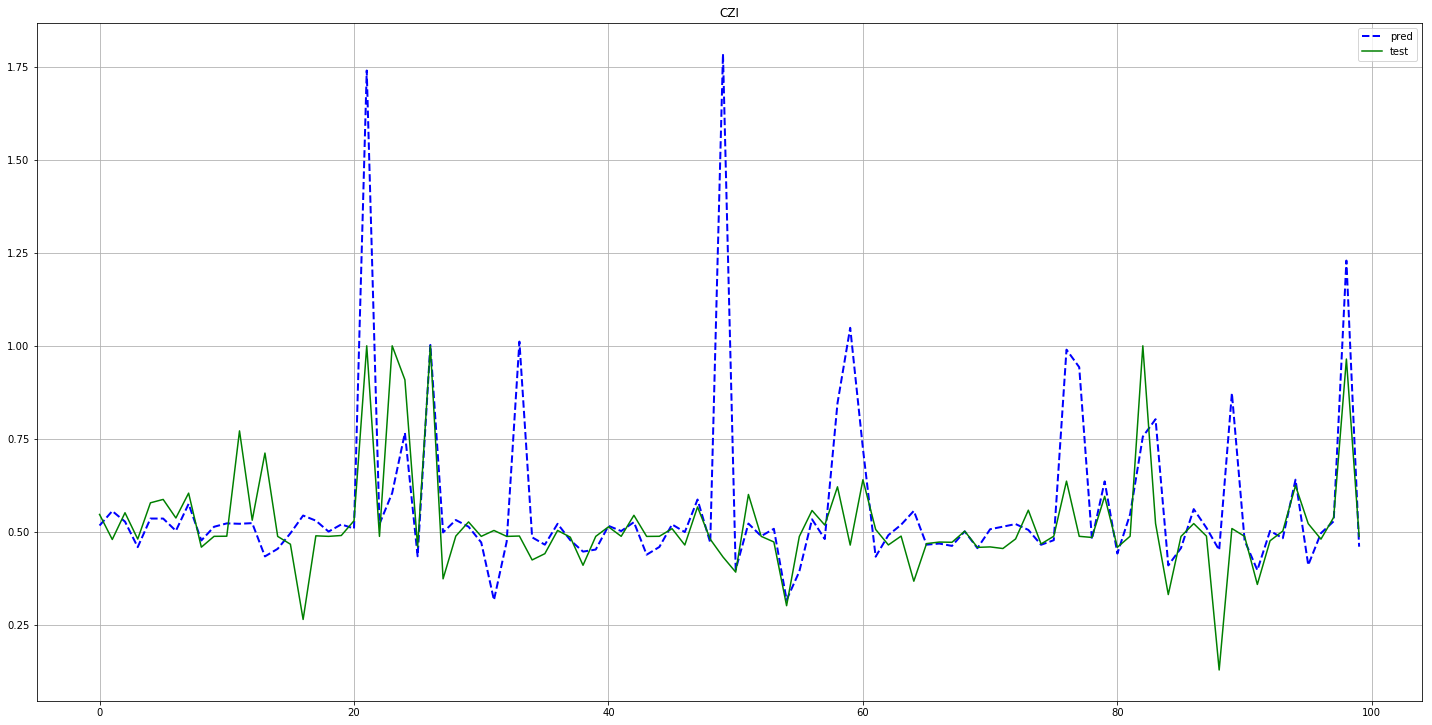

100
0.517305
0.556269
0.527844
0.459339
0.536091
0.536048
0.503141
0.575469
0.477212
0.514013
0.523108
0.522051
0.523769
0.434425
0.454778
0.496507
0.544182
0.530442
0.501017
0.520305
0.509262
1.73932
0.52128
0.60463
0.766232
0.43474
1.00238
0.498825
0.532152
0.514241
0.471837
0.317246
0.474102
1.01129
0.485647
0.465946
0.521939
0.477944
0.447328
0.452853
0.516494
0.502493
0.52646
0.439026
0.45976
0.520207
0.499755
0.587182
0.471289
1.78447
0.399041
0.522589
0.48898
0.508556
0.317497
0.393894
0.534017
0.481044
0.845603
1.04829
0.72398
0.43366
0.491586
0.519438
0.556616
0.465926
0.468922
0.462628
0.501776
0.456503
0.507445
0.514322
0.521262
0.5056
0.465619
0.477962
0.989684
0.942635
0.48058
0.635921
0.442011
0.547672
0.756009
0.802885
0.410217
0.456945
0.561457
0.511111
0.451464
0.872662
0.476983
0.397523
0.503008
0.483145
0.64052
0.411137
0.496804
0.528755
1.22891
0.460495


In [10]:
# 预测
test = [[ -2.21283262e-02,  -4.22827772e-02,  -1.22634684e-01,  -1.01158189e-01,
   -1.16706481e-01,  -3.61754572e-02]]
#t = ss_x.fit_transform(test)
test_pred = model_test(test_x_disorder, jy_Y_test, "CZI")
print(len(test_pred))
for i in range(0,len(test_pred)):
    print(test_pred[i][0])
